In [41]:
import flow.nflow as Flow
import torch
from flow.utils import MoonsDataset, plot_density, CircleGaussiansDataset, plot_samples
import flow.nets as NN
import flow.layers as L

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {device}')

Running on device: cpu


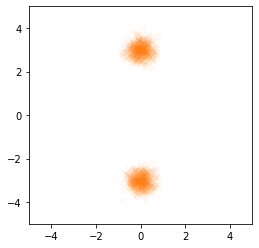

In [65]:
dataset_1 = CircleGaussiansDataset(n_samples=600, n_gaussians=2)
# dataset_1 = MoonsDataset(n_samples=500)
plt.figure(figsize=(4, 4))
plt.scatter(dataset_1.X[:,0], dataset_1.X[:,1], alpha=.05, marker='x', c='C1')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

In [66]:
def train(model, dataset, batch_size=100, max_epochs=1000, frequency=250, lr=1e-4, plot_name=""):
    """Train a normalizing flow model with maximum likelihood.

    Args:
        model: normalizing flow model. Flow or StackedFlows
        dataset: dataset containing data to fit. Dataset
        batch_size: number of samples per batch. int
        max_epochs: number of training epochs. int
        frequency: frequency for plotting density visualization. int
        
    Return:
        model: trained model. Flow or StackedFlows
        losses: loss evolution during training. list of floats
    """
    # Load dataset
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    # Train model
    losses = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0)
    for epoch in range(max_epochs + 1):
        total_loss = 0

        # decay LR twice

        if epoch == 400:
            optimizer.param_groups[0]['lr'] = lr * 0.1

        if epoch == 800:
            optimizer.param_groups[0]['lr'] = lr * 0.1

        for batch_index, (X_train) in enumerate(train_loader):
            log_prob = model.log_prob(X_train.clone())
            loss = -torch.mean(log_prob)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_loss /= len(train_loader)
        losses.append(total_loss)
        
        if epoch % frequency == 0:
            print(f"Epoch {epoch} -> loss: {total_loss:.2f}")
            plot_density(model, train_loader, device=device, name=f"{plot_name}epoch_{epoch}")
    
    return model, losses

In [67]:
# flow = Flow.RealNVPFlowBuilder(
#     masks=torch.tensor(
#         [[1., 0.],
#          [0., 1.],
#          [1., 0.],
#          [0., 1.],
#          [1., 0.],
#          [0., 1.],
#          [1., 0.],
#          [0., 1.]],
#     requires_grad=False),
#     hdim=32,
#     net_class=NN.ResNet,  # Adding normalization was paramount to stability
#   )()

flow = Flow.RadialFlowBuilder(dim=2,
                              nlayers=32,)()

# flow = Flow.PlanarFlowBuilder(dim=2,
#                               nlayers=8,)()

# flow = Flow.GlowBuilder(dim=2,
#                         hdim=32,
#                         nlayers=12,
#                         net_class=NN.MLP)()

Epoch 0 -> loss: 5.41
Epoch 100 -> loss: 1.51
Epoch 200 -> loss: 1.32
Epoch 300 -> loss: 1.24
Epoch 400 -> loss: 1.21
Epoch 500 -> loss: 1.20
Epoch 600 -> loss: 1.20
Epoch 700 -> loss: 1.19
Epoch 800 -> loss: 1.19
Epoch 900 -> loss: 1.19
Epoch 1000 -> loss: 1.19


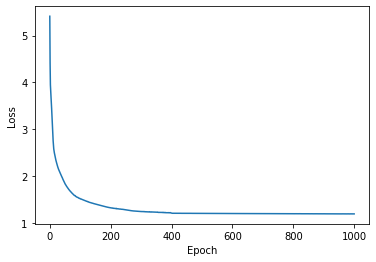

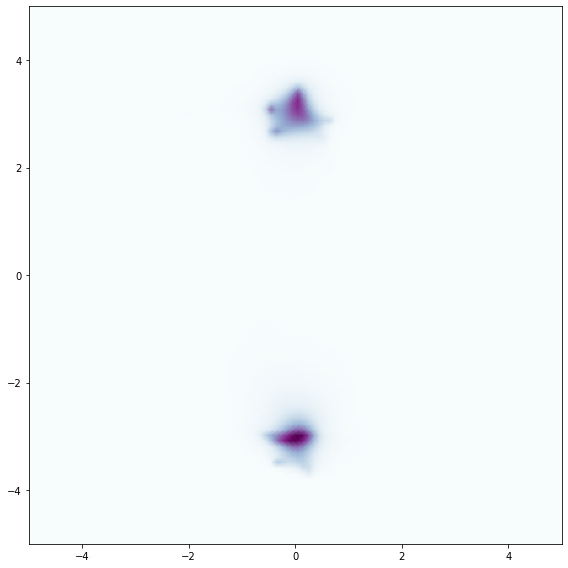

NotImplementedError: This flow has no forward path. So, cannot directly sample from it

<Figure size 432x288 with 0 Axes>

In [68]:
model, losses = train(flow, dataset=dataset_1, batch_size=64, max_epochs=1000, frequency=100, lr=1e-3)

# Plots
plt.figure()
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


plot_density(model, [], device=device)
plot_samples(model.train())

In [105]:
"""
Analytical inverse for the radial flow is not defined. However, given that we can compute the density for a sample x
using the differentiable flow, we effectively have an access to the score function s(x). Hence, we can try to sample
from it using Langeving dynamics by iteratively moving a random sample x to maximize the log probability.
"""

model = flow
lr = 0.01
n_samples = 32
samples = torch.zeros((n_samples, 2))

for n in range(n_samples):
    x = torch.randn((1, 2), requires_grad=True, dtype=torch.float32) # try sampling using gradient ascent
    for i in range(100):
        model.zero_grad()
        log_p = model.log_prob(x).sum()
        log_p.backward()
        x.data = x.data + lr * x.grad.data + (torch.sqrt(torch.tensor(2 * lr)) * torch.randn(x.shape))
        x.grad.data.zero_()
    samples[n] = x.data

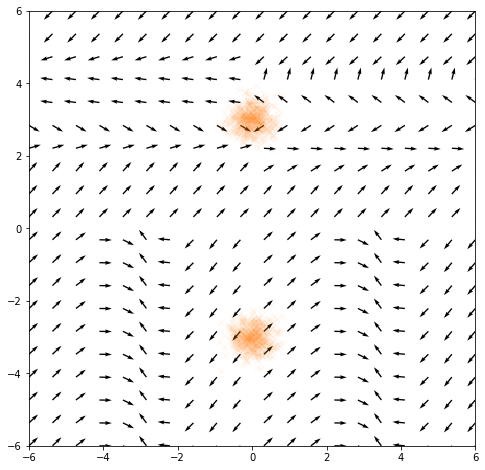

In [102]:
# plot the vector field of gradients. Moving in the direction of arrows increases the log prob of the samples
# You can observe that arrows often lead to the clusters of the gaussian

grid_size = 20

x,y = np.meshgrid(np.linspace(-6,6,grid_size),np.linspace(-6,6,grid_size))
inp = torch.cat([torch.from_numpy(x).float(), torch.from_numpy(y).float()])
inp_resh = inp.reshape(-1, 2)
inp_resh.requires_grad = True

grads = torch.zeros_like(inp_resh)

for i in range(inp_resh.shape[0]):
    model.zero_grad()
    inp = inp_resh[i].view(-1, 2)
    log_p = model.log_prob(inp)
    log_p.backward()
    grads[i] = inp_resh.grad.data[i] / torch.norm(inp_resh.grad.data[i])

grd_reshape = grads.reshape(grid_size, grid_size, 2)
u, v = grd_reshape[:, :, 0], grd_reshape[:, :, 1]

plt.figure(figsize=(8, 8))
plt.quiver(x, y, u, v)
plt.scatter(dataset_1.X[:,0], dataset_1.X[:,1], alpha=.05, marker='x', c='C1')
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

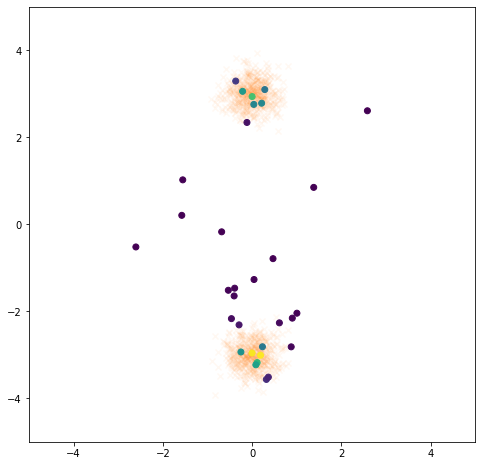

In [106]:
# Not ideal, but can be servicable.

log_prob = model.log_prob(samples)

plt.figure(figsize=(8, 8))
plt.scatter(dataset_1.X[:,0], dataset_1.X[:,1], alpha=.05, marker='x', c='C1')
plt.scatter(samples [:, 0].detach(), samples[:, 1].detach(), c=log_prob.detach().exp())
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

In [101]:
# trace the path of a single sample

model = flow
lr = 0.0001
n_samples = 1

plt.figure(figsize=(8, 8))

grid_size = 40

x, y = np.meshgrid(np.linspace(-5,5,grid_size),np.linspace(-5,5,grid_size))
inp = torch.cat([torch.from_numpy(x).float(), torch.from_numpy(y).float()])
inp_resh = inp.reshape(-1, 2)
inp_resh.requires_grad = True

grads = torch.zeros_like(inp_resh)

for i in range(inp_resh.shape[0]):
    model.zero_grad()
    inp = inp_resh[i].view(-1, 2)
    log_p = model.log_prob(inp)
    log_p.backward()
    grads[i] = inp_resh.grad.data[i] / torch.norm(inp_resh.grad.data[i])
    
    for grad in inp_resh.grad.data:
        grad = 0

grd_reshape = grads.reshape(grid_size, grid_size, 2)
u, v = grd_reshape[:, :, 0], grd_reshape[:, :, 1]
plt.quiver(x, y, u, v)

for n in range(n_samples):
    path = torch.zeros(300, 2)
    x = torch.randn((1, 2), requires_grad=True, dtype=torch.float32) # try sampling using gradient ascent
    for i in range(300):
        model.zero_grad()
        log_p = model.log_prob(x).sum()
        log_p.backward()
        x.data = x.data + lr * x.grad.data + (torch.sqrt(torch.tensor(2 * lr)) * torch.randn(x.shape))
        path[i] = x.data
        
plt.scatter(dataset_1.X[:,0], dataset_1.X[:,1], alpha=.05, marker='o', c='C1')
plt.scatter(path[0, 0].detach(), path[0, 1].detach(), c="red", marker="x")
plt.scatter(path[-1, 0].detach(), path[-1, 1].detach(), c="orange", marker="x")
plt.plot(path[:, 0].detach(), path[:, 1].detach(), c="blue")

plt.xlim(-5, 5)
plt.ylim(-5, 5)

plt.savefig("path.png", dpi=200)
plt.close()